# Ayudantía A8: Exploración de Datos Climáticos en Chile

En esta ayudantía practicaremos conceptos fundamentales de **análisis exploratorio de datos (EDA)** utilizando un conjunto de datos de precipitaciones diarias en distintas regiones de Chile.

Trabajaremos con:
- Datos en formato tipo parquet (simulado aquí en memoria).
- Agrupaciones por región y año.
- Estadísticos descriptivos.
- Visualizaciones con `matplotlib`, `seaborn` y `geopandas`.
- Mapas coropléticos y, de forma opcional, animaciones temporales.




## 1. Setup Inicial

Importaremos las librerías necesarias y configuraremos el entorno gráfico.


In [1]:
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import json 

# esto es opcional y nos permite cierta coherencia en los graficos que utilizamos - ademas de ser más estilizados que los por defecto de matplot.
plt.style.use('seaborn-v0_8')
sns.set_theme()

# Aseguramos reproducibilidad
np.random.seed(42)

## 2. Obtención de datos

Vamos a trabajar con datos climáticos de la Dirección Meteorológica de Chile. 
<br>
Estos datos se pueden obtener a través de su API pública, para lo cual es necesario registrarse. 
<br>
Registro :
- https://climatologia.meteochile.gob.cl/application/usuario/registroUsuario

In [2]:
# importamos la  .env file
from dotenv import load_dotenv
import os

load_dotenv() # carga las variables desde el .env

API_KEY = os.getenv("API_KEY")
USUARIO = os.getenv("USUARIO")

BASE_URL = f"https://climatologia.meteochile.gob.cl/application/geoservicios/getCatastroEstacionesGeo?usuario={USUARIO}&token={API_KEY}"

response = requests.get(BASE_URL)
data_inicial = response.json()

In [3]:
data_inicial = pd.json_normalize(data_inicial['features'])

## 3. Exploración Inicial

Antes de cualquier análisis, es importante inspeccionar la estructura general del dataset.


In [4]:
# nos hacemos una idea
display(data_inicial.head())

# info general del dataframe
data_inicial.info()


,type,features.type,features.geometry.type,features.geometry.coordinates,features.properties.nombreEstacion,features.properties.CodigoNacional,features.properties.codigoWIGOS,features.properties.codigoOACI,features.properties.CodigoOMM,features.properties.latitud,features.properties.longitud,features.properties.altitud,features.properties.NumeroRegion,features.properties.region,features.properties.provincia,features.properties.comuna,features.properties.fechaInstalacion,features.properties.tipoEstacion,features.properties.tipoClasificacion,features.properties.zonaGeografica
0,Feature,Feature,Point,"[-70.68278, -33.445]","Quinta Normal, Santiago",330020,0-20000-0-85577,SCQN,85577,-33.44500,-70.68278,520,13,,Santiago,Estación Central,1849-01-01 00:00:00,Mixta,Sinóptica,Valle
1,Feature,Feature,Point,"[-70.78778, -33.37833]",Pudahuel Santiago,330021,0-20000-0-85574,SCEL,85574,-33.37833,-70.78778,474,13,,Santiago,Pudahuel,1967-02-01 12:00:00,Mixta,Sinóptica Aeronáutica,Valle
2,Feature,Feature,Point,"[-70.34028, -18.35556]","Chacalluta, Arica Ap.",180005,0-20000-0-85406,SCAR,85406,-18.35556,-70.34028,51,15,,Arica,Arica,1958-01-01 00:00:00,Mixta,Sinóptica Aeronáutica,Litoral
3,Feature,Feature,Point,"[-70.44528, -23.45361]",Cerro Moreno Antofagasta Ap.,230001,0-20000-0-85442,SCFA,85442,-23.45361,-70.44528,139,2,,Antofagasta,Antofagasta,1944-06-03 00:00:00,Mixta,Sinóptica Aeronáutica,Litoral
4,Feature,Feature,Point,"[-109.4325, -27.15889]",Mataveri Isla de Pascua Ap.,270001,0-20000-0-85469,SCIP,85469,-27.15889,-109.43250,69,5,,Isla de Pascua,Isla de Pascua,1937-07-01 00:00:00,Mixta,Sinóptica Aeronáutica,Litoral


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 699 entries, 0 to 698
Data columns (total 20 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   type                                   699 non-null    object 
 1   features.type                          699 non-null    object 
 2   features.geometry.type                 699 non-null    object 
 3   features.geometry.coordinates          699 non-null    object 
 4   features.properties.nombreEstacion     699 non-null    object 
 5   features.properties.CodigoNacional     699 non-null    int64  
 6   features.properties.codigoWIGOS        699 non-null    object 
 7   features.properties.codigoOACI         699 non-null    object 
 8   features.properties.CodigoOMM          699 non-null    object 
 9   features.properties.latitud            699 non-null    float64
 10  features.properties.longitud           699 non-null    float64
 11  featur

Como podemos ver, en la llamada a ese **endpoint** nos devuelve un JSON con todas las estaciones meteorológicas que tiene la Dirección Meteorológica de Chile. 
En esta sesión, en función al avance que hemos tenido en el curso, vamos a realizar las siguientes tareas:
1. Hacer un análisis exploratorio de los datos.
2. Queremos armar un mapa de precipitaciones promedio de Chile ¿Cómo lo hacemos?
    - ¿Que necesitamos? 
3. ¿Cómo podemos obtener los datos de precipitaciones de cada estación?
   - ¿Qué endpoint necesitamos? 


- Observa los tipos de datos y las columnas. ¿Qué representa cada una?
- ¿Hay columnas que deberían transformarse?
- ¿Qué decisiones tomarías si hubiera valores nulos o duplicados?


In [5]:
data_inicial.isnull().sum()

type                                     0
features.type                            0
features.geometry.type                   0
features.geometry.coordinates            0
features.properties.nombreEstacion       0
features.properties.CodigoNacional       0
features.properties.codigoWIGOS          0
features.properties.codigoOACI           0
features.properties.CodigoOMM            0
features.properties.latitud              0
features.properties.longitud             0
features.properties.altitud              0
features.properties.NumeroRegion         0
features.properties.region               0
features.properties.provincia            0
features.properties.comuna               0
features.properties.fechaInstalacion     0
features.properties.tipoEstacion         0
features.properties.tipoClasificacion    0
features.properties.zonaGeografica       0
dtype: int64

## 4. Análisis Descriptivo por Región y Año

Investigando la API, podemos encontrar la ruta que permite obtener los datos de precipitaciones de una estación en particular, dado el código de la estación. 
<br>
La ruta es similar a la anterior, pero ahora ocupamos `.../getAguaCaidaDiaria/{codigoEstacion}/{headers}`. 


In [6]:
# por ejemplo, para santiago (Estación de Quinta Normal) : 

URL_SANTIAGO = f"https://climatologia.meteochile.gob.cl/application/serviciosb/getAguaCaidaDiaria/330020?usuario={USUARIO}&token={API_KEY}"
response_santiago = requests.get(URL_SANTIAGO)
data_santiago = response_santiago.json()

In [7]:
df2 = pd.json_normalize(data_santiago)

Observemos que los datos del JSON están anidados, por lo que para transformarlos en un DataFrame, podemos usar la función `json_normalize` de pandas.
<br>
Aún así, vemos que tenemos 33431 columnas y 1 fila, lo que nos indica que los datos siguen estando anidados.
<br>
Para solucionar esto debemos explorar el formato del JSON y observar cómo obtener aquello que buscamos, en el formato que necesitamos.

In [8]:
df2

,pais,organismo,fechaCreacion,timezone,producto,datosEstacion.codigoNacional,datosEstacion.codigoOMM,datosEstacion.codigoOACI,datosEstacion.nombreEstacion,datosEstacion.latitud,...,datosHistoricos.diaria.2025.6.26.traza,datosHistoricos.diaria.2025.6.27.parcial,datosHistoricos.diaria.2025.6.27.total,datosHistoricos.diaria.2025.6.27.traza,datosHistoricos.diaria.2025.6.28.parcial,datosHistoricos.diaria.2025.6.28.total,datosHistoricos.diaria.2025.6.28.traza,datosHistoricos.diaria.2025.6.29.parcial,datosHistoricos.diaria.2025.6.29.total,datosHistoricos.diaria.2025.6.29.traza
0,Chile,Dirección Meteorlógica de Chile,30-06-2025 14:10,UTC,Agua histórica diaria 30 años recientes.,330020,85577,SCQN,"Quinta Normal, Santiago",-33.44500,...,0,0,0,0,0,0,0,0,0,0


<p align="center">
    <img src="src/json_format.png" alt="json_format" width="600"/>
</p>

De esto vemos que lo que nos interesa está dentro de `datosHistoricos`, <br>
y dentro de esto `diaria` [que corresponde a la información diaria de precipitaciones diarias x año].


In [9]:
diaria = data_santiago["datosHistoricos"]["diaria"]
diaria 

{'1995': {'1': {'1': {'parcial': 0, 'total': 0, 'traza': 0},
   '2': {'parcial': 0, 'total': 0, 'traza': 0},
   '3': {'parcial': 0, 'total': 0, 'traza': 0},
   '4': {'parcial': 0, 'total': 0, 'traza': 0},
   '5': {'parcial': 0, 'total': 0, 'traza': 0},
   '6': {'parcial': 0, 'total': 0, 'traza': 0},
   '7': {'parcial': 0, 'total': 0, 'traza': 0},
   '8': {'parcial': 0, 'total': 0, 'traza': 0},
   '9': {'parcial': 0, 'total': 0, 'traza': 0},
   '10': {'parcial': 0, 'total': 0.6000000238418579, 'traza': 0},
   '11': {'parcial': 0, 'total': 0, 'traza': 0},
   '12': {'parcial': 0, 'total': 0, 'traza': 0},
   '13': {'parcial': 0, 'total': 0, 'traza': 0},
   '14': {'parcial': 0, 'total': 0, 'traza': 0},
   '15': {'parcial': 0, 'total': 0, 'traza': 0},
   '16': {'parcial': 0, 'total': 0, 'traza': 0},
   '17': {'parcial': 0, 'total': 0, 'traza': 0},
   '18': {'parcial': 0, 'total': 0, 'traza': 0},
   '19': {'parcial': 0, 'total': 0, 'traza': 0},
   '20': {'parcial': 0, 'total': 0, 'traza': 0},

Ahora vemos que `diaria` nos proporciona un diccionario con años como llaves, y listas de diccionarios como valores.
<br>
Cada diccionario dentro de las listas corresponde a un día del año, y tiene la siguiente estructura:
- `mes`: mes (1-12)
- `dia`: día 
- `año`: año (ej: 2023)
- `parcial`: Suma del agua caída díaria (sin importar la cantidad de observaciones que se dispongan)
- `total`:  Suma del agua caída díaria (deben estár disponibles todas las observaciones del día)
- `traza`: Valor mayor que 0 indica presencia de precipitación menor a 0.1 mm.

In [10]:
rows = []

# dada la jerarquia del JSON, iteramos de esta forma para obtener los valores atomicos que necesitamos
for year, months in diaria.items():
    for month, days in months.items():
        for day, valores in days.items():
            row = {
                "año": int(year),
                "mes": int(month),
                "día": int(day),
                "parcial": valores["parcial"],
                "total": valores["total"],
                "traza": valores["traza"]
            }
            rows.append(row)

df2 = pd.DataFrame(rows)
df2

,año,mes,día,parcial,total,traza
0,1995,1,1,0,0.0,0
1,1995,1,2,0,0.0,0
2,1995,1,3,0,0.0,0
3,1995,1,4,0,0.0,0
4,1995,1,5,0,0.0,0
...,...,...,...,...,...,...
11133,2025,6,25,0,0.0,0
11134,2025,6,26,0,0.0,0
11135,2025,6,27,0,0.0,0
11136,2025,6,28,0,0.0,0


In [11]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11138 entries, 0 to 11137
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   año      11138 non-null  int64  
 1   mes      11138 non-null  int64  
 2   día      11138 non-null  int64  
 3   parcial  11138 non-null  int64  
 4   total    11138 non-null  float64
 5   traza    11138 non-null  int64  
dtypes: float64(1), int64(5)
memory usage: 522.2 KB


In [12]:
df2.describe()

,año,mes,día,parcial,total,traza
count,11138.000000,11138.000000,11138.000000,11138.0,11138.000000,11138.000000
mean,2009.750853,6.473783,15.726881,0.0,0.745807,0.042288
std,8.805642,3.448994,8.799061,0.0,4.231239,0.201254
min,1995.000000,1.000000,1.000000,0.0,0.000000,0.000000
25%,2002.000000,3.000000,8.000000,0.0,0.000000,0.000000
50%,2010.000000,6.000000,16.000000,0.0,0.000000,0.000000
75%,2017.000000,9.000000,23.000000,0.0,0.000000,0.000000
max,2025.000000,12.000000,31.000000,0.0,111.099998,1.000000


### Ejercicio
- ¿Qué regiones son las más lluviosas en promedio?
- ¿Existen diferencias marcadas entre regiones?


In [13]:
# para resolver esto necesitaremos iterar requests a la API para cada region 
estacion_codigo = zip ( data_inicial['features.properties.nombreEstacion'], data_inicial['features.properties.CodigoNacional'])
estacion_codigo = dict(estacion_codigo)
estacion_codigo

{'Quinta Normal, Santiago': 330020,
 'Pudahuel Santiago ': 330021,
 'Chacalluta, Arica Ap.': 180005,
 'Cerro Moreno  Antofagasta  Ap.': 230001,
 'Mataveri  Isla de Pascua Ap.': 270001,
 'Desierto de Atacama, Caldera  Ad.': 270008,
 'El Tepual  Puerto Montt Ap.': 410005,
 'Carlos Ibañez, Punta Arenas Ap.': 520006,
 'La Florida, La Serena Ad.': 290004,
 'Diego Aracena Iquique Ap.': 200006,
 'Eulogio Sánchez, Tobalaba Ad.': 330019,
 'Rodelillo, Ad.': 330007,
 'Santo Domingo, Ad.': 330030,
 'Juan Fernández, Estación Meteorológica.': 330031,
 'General Freire, Curicó Ad.': 340031,
 'Carriel Sur, Concepción Ap.': 360019,
 'Puerto Aysén Ad.': 450001,
 "General Bernardo O'Higgins, Chillán Ad.": 360011,
 'María Dolores, Los Angeles Ad.': 370033,
 'Maquehue, Temuco Ad.': 380013,
 'Pichoy, Valdivia Ad.': 390006,
 'Cañal Bajo,  Osorno Ad.': 400009,
 'Sta. Bárbara Ad. (pista de emergencia)': 420013,
 'Chaitén, Ad.': 420004,
 'Futaleufú Ad.': 430002,
 'Alto Palena Ad.': 430004,
 'Teniente Vidal, Coyh

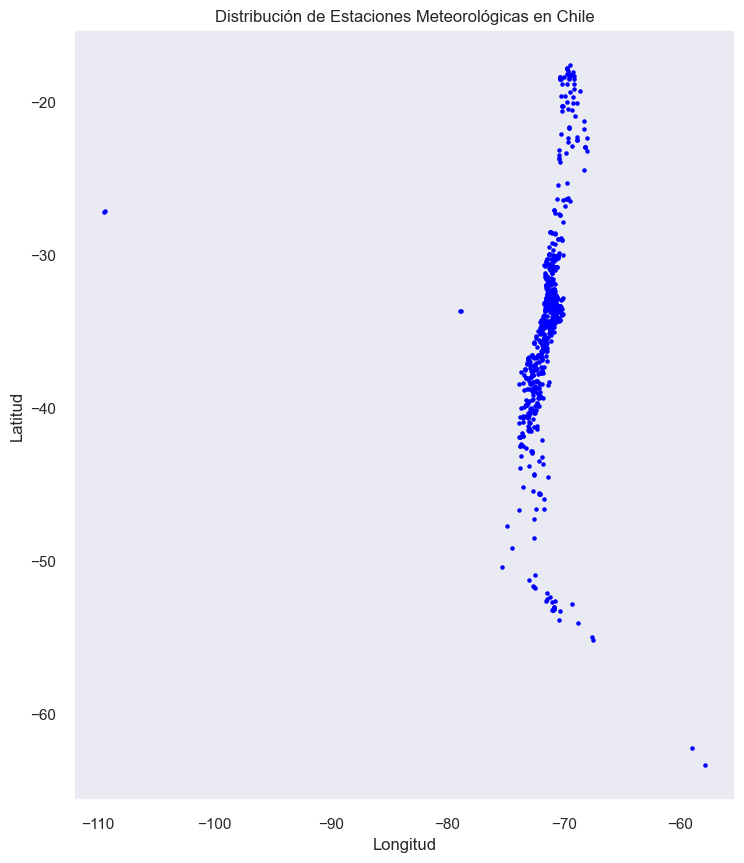

In [14]:
# primero veamos su distribución a lo largo del mapa.  
gdf = gpd.GeoDataFrame(data_inicial, geometry=gpd.points_from_xy(data_inicial['features.properties.longitud'], data_inicial['features.properties.latitud']))
gdf.set_crs(epsg=4326, inplace=True)
gdf.plot(figsize=(10, 10), color='blue', markersize=5)
plt.title('Distribución de Estaciones Meteorológicas en Chile')
plt.xlabel('Longitud')
plt.ylabel('Latitud')
plt.grid()
plt.show()

#### llamados a la API 
- ¿Cómo guardamos los datos de todas las estaciones? 

In [15]:
import tqdm  # libreria para ver progreso en loops largos

In [16]:
# RECOLECCION TOMA APROXIMADAMENTE 3-4 MINUTOS

# descomentar para ejecutar

ESTACION = ""

for estaciones, codigo in tqdm.tqdm(estacion_codigo.items()):
    ESTACION = codigo
    URL_ESTACION = f"https://climatologia.meteochile.gob.cl/application/serviciosb/getAguaCaidaDiaria/{ESTACION}?usuario={USUARIO}&token={API_KEY}" 
    data = requests.get(URL_ESTACION) 
    data_estacion = data.json()
    if os.path.exists("data") == False:
        os.mkdir("data")
    with open(f"data/{estaciones.replace(' ', '_')}_data.json", 'w') as f:
        json.dump(data_estacion, f, indent=4)

    

100%|██████████| 697/697 [00:56<00:00, 12.32it/s]


In [17]:
def crear_df_estacion(datos_diarios):
    rows = []
    for year, months in datos_diarios.items():
        for month, days in months.items():
            for day, valores in days.items():
                row = {
                    "año": int(year),
                    "mes": int(month),
                    "día": int(day),
                    "parcial": valores["parcial"],
                    "total": valores["total"],
                    "traza": valores["traza"]
                }
                rows.append(row)

    df_estacion = pd.DataFrame(rows)
    return df_estacion

Ahora que tenemos los datos de cada estación podemos generar un DF para cada estación, obtener lo que nos interesa y responder las preguntas anteriores.

In [18]:
estaciones = {}

for e, c in tqdm.tqdm(estacion_codigo.items()):
    # ocupamos el formato en el que guardamos los archivos 
    with open(f"data/{e.replace(' ', '_')}_data.json", 'r') as f:
        try:
            data_estacion = json.load(f)
            diaria = data_estacion["datosHistoricos"]["diaria"]
            estaciones[c] = crear_df_estacion(diaria)
        except json.JSONDecodeError:
            with open(f"data/error_log.txt","a") as log_file:
                log_file.write(f"Error al decodificar el JSON para la estación {e}\n")
        except KeyError as ke:
            with open(f"data/error_log.txt","a") as log_file:
                log_file.write(f"Falta la clave {ke} en los datos para la estación {e}\n")
        except Exception as ex:
            with open(f"data/error_log.txt","a") as log_file:
                log_file.write(f"Ocurrió un error inesperado para la estación {e}: {ex}\n")


100%|██████████| 697/697 [00:01<00:00, 588.67it/s] 


In [19]:
len(estaciones)

125

Observemos que tenemos al rededor de un $\frac{1}{5}$ de las estaciones iniciales, ya que la API responde con que no tiene la información disponible.

Obtengamos el promedio general de precipitaciones por cada estación. Es decir, calcualremos el promedio para cada estación, para esto ocuparemos los datos almacenados en la variable `total`.

In [20]:
# debemos iterar sobre cada df en estaciones, obtener el promedio de la columna `total` y guardarlo en una lista
promedios = {}
for c, df in estaciones.items():
    try :
        promedios[c] = df['total'].mean()
    except Exception as ex:
        with open(f"data/error_promedios_log.txt","a") as log_file:
            log_file.write(f"Ocurrió un error inesperado para la estación {df['estacion'].iloc[0]}: {ex}\n")

promedios_ord = dict(sorted(promedios.items(), key=lambda item: item[1], reverse=True))
promedios_ord
  

{420004: 9.430443710839604,
 390043: 7.173048526076168,
 440004: 7.059999986682777,
 450001: 6.164157306436407,
 420015: 5.9725517266372155,
 430009: 5.822830078289548,
 420014: 5.6032366310555535,
 430002: 5.349464642420864,
 430001: 5.34171055694694,
 390028: 4.555990210649146,
 390006: 4.459728829868394,
 400060: 4.286558348746032,
 410005: 4.006320703989418,
 410026: 3.9959599996030333,
 430004: 3.878417433127349,
 380080: 3.7775525679873363,
 400033: 3.4376623154348964,
 380082: 3.3325842700449635,
 410027: 3.2300231795602548,
 400009: 3.1795519970614796,
 380029: 2.971897715225902,
 380013: 2.893400277910114,
 360046: 2.8788250497006618,
 380018: 2.8177865541440696,
 390029: 2.814333609206179,
 450004: 2.765442631014921,
 400013: 2.728210418025448,
 380033: 2.7239520910547346,
 480002: 2.6448275844855553,
 330031: 2.6433387291502157,
 370033: 2.611436634348744,
 410040: 2.560515021342284,
 360019: 2.550933738011505,
 360011: 2.362874842894545,
 470001: 1.899745164909652,
 370036:

In [21]:
len(promedios_ord)

125

Ahora podemos emparejar estos promedios con la información geoespacial de las estaciones y visualizarlo en un mapa coroplético.

In [22]:
df_promedios = pd.DataFrame(list(promedios_ord.items()), columns=['CodigoNacional', 'PromedioPrecipitacion'])
df_promedios

,CodigoNacional,PromedioPrecipitacion
0,420004,9.430444
1,390043,7.173049
2,440004,7.060000
3,450001,6.164157
4,420015,5.972552
...,...,...
120,180042,0.005244
121,200010,0.001594
122,200006,0.001472
123,230022,0.000308


In [23]:
# unimos la info de promedios con la info geoespacial de las estaciones
gdf_promedios = gdf.merge(df_promedios, left_on='features.properties.CodigoNacional', right_on='CodigoNacional')
gdf_promedios

,type,features.type,features.geometry.type,features.geometry.coordinates,features.properties.nombreEstacion,features.properties.CodigoNacional,features.properties.codigoWIGOS,features.properties.codigoOACI,features.properties.CodigoOMM,features.properties.latitud,...,features.properties.region,features.properties.provincia,features.properties.comuna,features.properties.fechaInstalacion,features.properties.tipoEstacion,features.properties.tipoClasificacion,features.properties.zonaGeografica,geometry,CodigoNacional,PromedioPrecipitacion
0,Feature,Feature,Point,"[-70.68278, -33.445]","Quinta Normal, Santiago",330020,0-20000-0-85577,SCQN,85577,-33.44500,...,,Santiago,Estación Central,1849-01-01 00:00:00,Mixta,Sinóptica,Valle,POINT (-70.68278 -33.445),330020,0.745807
1,Feature,Feature,Point,"[-70.78778, -33.37833]",Pudahuel Santiago,330021,0-20000-0-85574,SCEL,85574,-33.37833,...,,Santiago,Pudahuel,1967-02-01 12:00:00,Mixta,Sinóptica Aeronáutica,Valle,POINT (-70.78778 -33.37833),330021,0.579530
2,Feature,Feature,Point,"[-70.34028, -18.35556]","Chacalluta, Arica Ap.",180005,0-20000-0-85406,SCAR,85406,-18.35556,...,,Arica,Arica,1958-01-01 00:00:00,Mixta,Sinóptica Aeronáutica,Litoral,POINT (-70.34028 -18.35556),180005,0.005881
3,Feature,Feature,Point,"[-70.44528, -23.45361]",Cerro Moreno Antofagasta Ap.,230001,0-20000-0-85442,SCFA,85442,-23.45361,...,,Antofagasta,Antofagasta,1944-06-03 00:00:00,Mixta,Sinóptica Aeronáutica,Litoral,POINT (-70.44528 -23.45361),230001,0.010234
4,Feature,Feature,Point,"[-70.78111, -27.25444]","Desierto de Atacama, Caldera Ad.",270008,0-20000-0-85467,SCAT,85467,-27.25444,...,,Copiapó,Caldera,2005-01-20 00:00:00,Mixta,Sinóptica Aeronáutica,Secano Costero,POINT (-70.78111 -27.25444),270008,0.033626
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120,Feature,Feature,Point,"[-70.95944, -31.78722]",Salamanca Pisco Capel,310044,0-152-0-310044,,,-31.78722,...,,Choapa,Salamanca,2023-08-10 13:28:43,Automática,Climatológica - Satelital,Valle,POINT (-70.95944 -31.78722),310044,0.581029
121,Feature,Feature,Point,"[-72.65889, -40.08361]","Fundo el Maitén, Paillaco",400060,,,,-40.08361,...,,Valdivia,Paillaco,2023-08-21 15:18:02,Automática,Climatológica - Satelital,Valle,POINT (-72.65889 -40.08361),400060,4.286558
122,Feature,Feature,Point,"[-72.21944, -36.50556]",Liceo Polivalente San Nicolás,360097,0-152-0-360097,,,-36.50556,...,,Punilla,San Nicolás,2023-08-29 18:42:23,Automática,Climatológica,Secano Interior,POINT (-72.21944 -36.50556),360097,1.381206
123,Feature,Feature,Point,"[-70.70417, -32.57083]",El Tártaro (Putaendo),320121,0-152-0-320121,,,-32.57083,...,,San Felipe de Aconcagua,Putaendo,2024-02-05 12:47:37,Automática,Climatológica,Valle,POINT (-70.70417 -32.57083),320121,1.048585


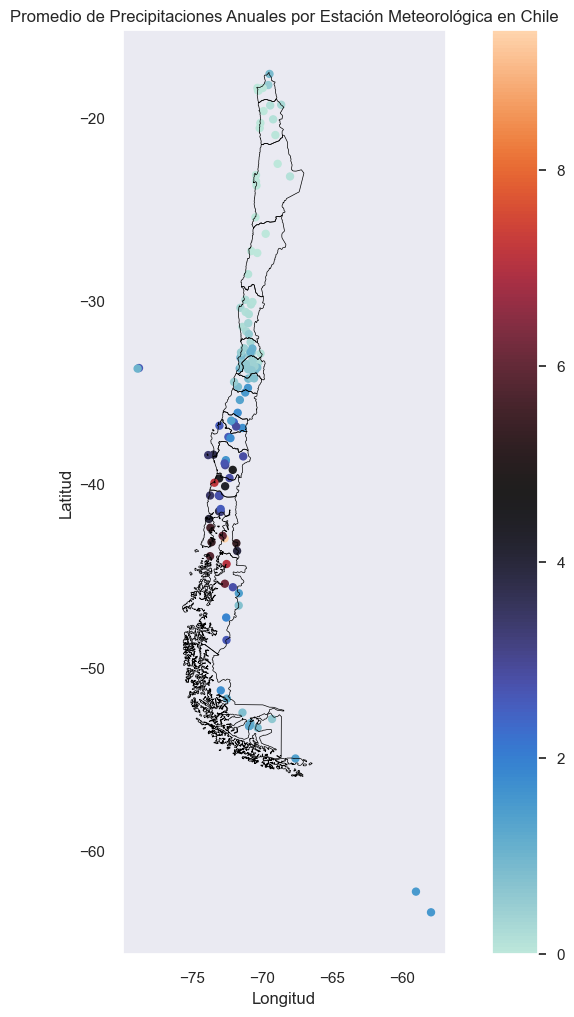

In [24]:
# visualizamos en un mapa coroplético
# mezclamos con el archivo .shp de chile para tener un mejor contexto
shapefile_path = "src/cl_shp/cl.shp"
chile = gpd.read_file(shapefile_path)
chile = chile.to_crs(epsg=4326)

fig, ax = plt.subplots(figsize=(12, 12))
chile.boundary.plot(ax=ax, color='black', linewidth=0.5)
gdf_promedios.plot(column='PromedioPrecipitacion', ax=ax, legend=True, cmap='icefire', markersize=25, alpha=1)
plt.title('Promedio de Precipitaciones Anuales por Estación Meteorológica en Chile')
plt.xlabel('Longitud')
plt.ylabel('Latitud')
plt.grid()
plt.show()

## 5. Visualizaciones Estadísticas

Utilizaremos gráficos para explorar patrones de precipitación por estacion  en el tiempo.


In [25]:
# consigamos los maximos de cada año por estacion, luego el maximo de esos maximos por estacion
maximos_anuales = {}
for i in range(1995,2025):
    maximos_anuales[i] = {}
    for c, df in estaciones.items():
        maximos_anuales[i][c] = df[df['año'] == i]['total'].max()

# ahora busquemos el maximo de cada año 
maximos_totales = {}
for year, estaciones_max in maximos_anuales.items():
    maximo = max(estaciones_max.values())
    codigo = [est for est, val in estaciones_max.items() if val == maximo]
    maximos_totales[year] = [round(maximo,2), *codigo]
maximos_totales

{1995: [90.0, 420004],
 1996: [125.0, 430001],
 1997: [148.7, 360019],
 1998: [81.4, 420004],
 1999: [176.0, 450001],
 2000: [167.6, 330007],
 2001: [221.3, 330007],
 2002: [236.4, 330007],
 2003: [150.0, 430004],
 2004: [127.6, 390006],
 2005: [162.4, 360019],
 2006: [149.9, 330007],
 2007: [69.7, 420004],
 2008: [186.2, 430002],
 2009: [123.3, 330007],
 2010: [150.0, 450001],
 2011: [138.0, 430002],
 2012: [105.2, 330030],
 2013: [126.0, 430001],
 2014: [173.0, 430002],
 2015: [145.8, 420014],
 2016: [97.8, 330113],
 2017: [240.0, 400033],
 2018: [144.7, 330031],
 2019: [111.1, 390043],
 2020: [289.8, 330066],
 2021: [126.8, 390043],
 2022: [136.4, 380018],
 2023: [217.4, 360042],
 2024: [118.9, 360042]}

In [26]:
#pasamos a un DatafRAME

max_precipitaciones = pd.DataFrame([
    {'año': año, 'max_año': valores[0], 'cod_estacion': valores[1]} 
    for año, valores in maximos_totales.items()
])
max_precipitaciones

,año,max_año,cod_estacion
0,1995,90.0,420004
1,1996,125.0,430001
2,1997,148.7,360019
3,1998,81.4,420004
4,1999,176.0,450001
5,2000,167.6,330007
6,2001,221.3,330007
7,2002,236.4,330007
8,2003,150.0,430004
9,2004,127.6,390006


In [27]:
# merge con el original para obtner nombres estaciones 
nom_cod = data_inicial[['features.properties.nombreEstacion','features.properties.CodigoNacional']]
max_total = max_precipitaciones.merge(nom_cod, left_on="cod_estacion", right_on="features.properties.CodigoNacional")


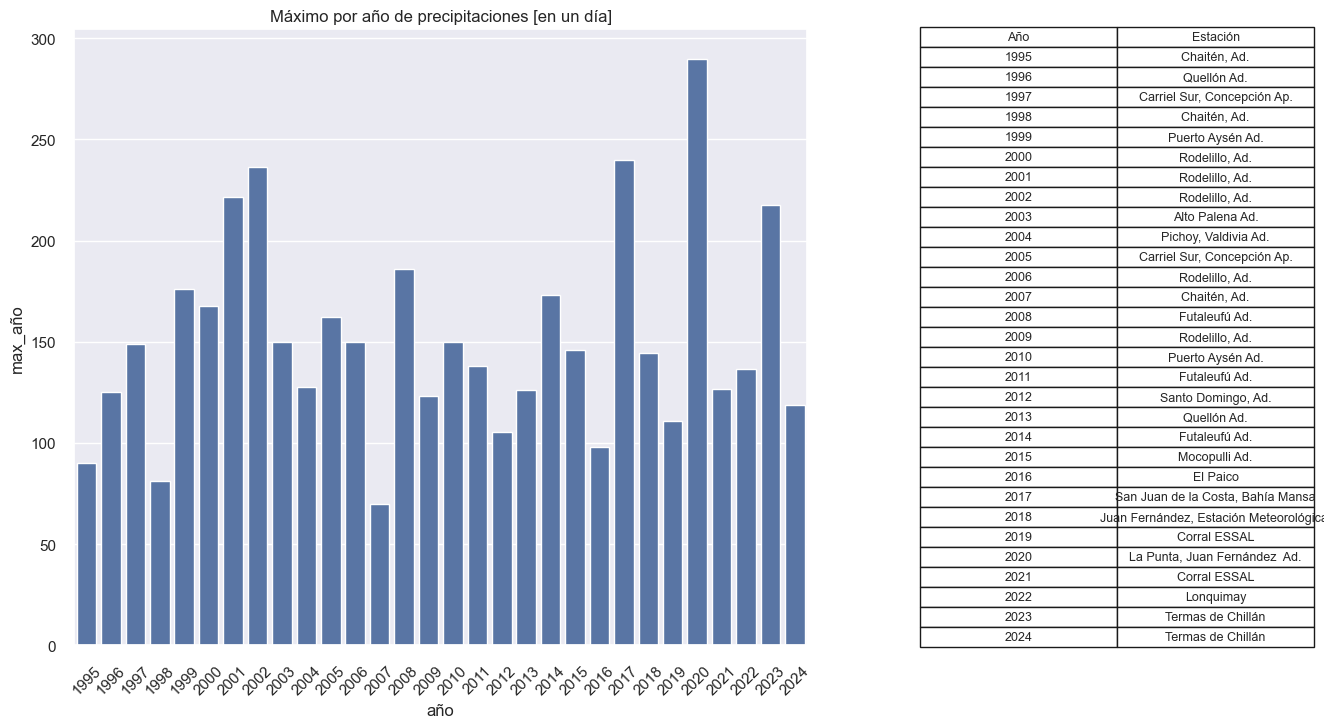

In [28]:


# ploteamos
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8), gridspec_kw={'width_ratios': [65, 35]})


sns.barplot(x='año', y='max_año', data=max_total, ax=ax1)
ax1.tick_params(axis='x', rotation=45)
ax1.set_title('Máximo por año de precipitaciones [en un día]')

#tabla de nombres
cell_text = [[año, estacion] for año, estacion in zip(max_total['año'], max_total['features.properties.nombreEstacion'])]
tabla = ax2.table(cellText=cell_text,
                 colLabels=['Año', 'Estación'],
                 loc='center',
                 cellLoc='center')
tabla.auto_set_font_size(False)
tabla.set_fontsize(9)
tabla.scale(1, 1.2) 
ax2.axis('off') 

plt.show()

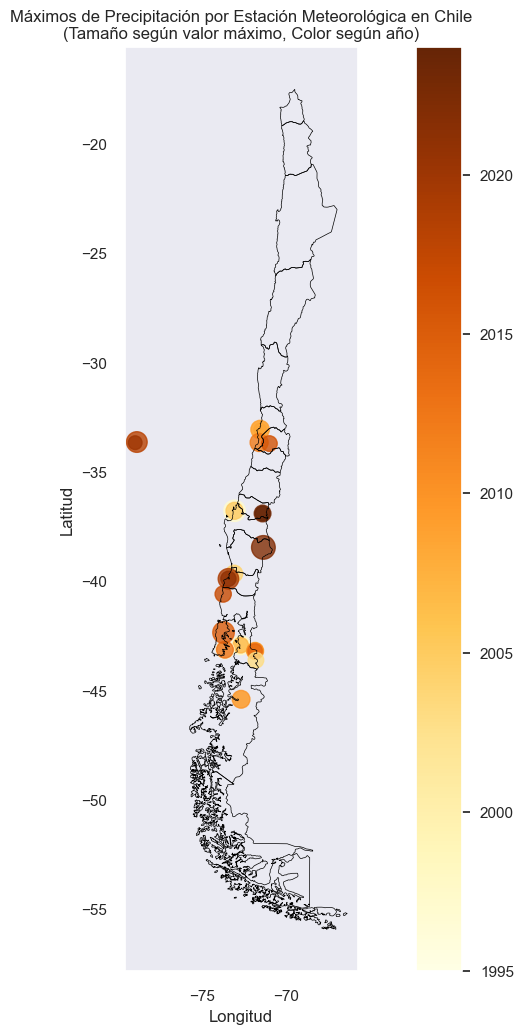

In [29]:
# otra visualizacion 

shapefile_path = "src/cl_shp/cl.shp"
chile = gpd.read_file(shapefile_path)
chile = chile.to_crs(epsg=4326)

#agregamos las coordernadas 

gdf_max_pre = gdf.merge(max_total, on = "features.properties.nombreEstacion")

fig, ax = plt.subplots(figsize=(15, 12))
chile.boundary.plot(ax=ax, color='black', linewidth=0.5)

# Plotear puntos con tamaño variable y color por año

gdf_max_pre.plot(column='año', 
                ax=ax, 
                legend=True, 
                cmap='YlOrBr',  # o otro colormap para años
                markersize=max_total['max_año'],  # Ajusta el divisor según tus valores
                alpha=0.8)

plt.title('Máximos de Precipitación por Estación Meteorológica en Chile\n(Tamaño según valor máximo, Color según año)')
plt.xlabel('Longitud')
plt.ylabel('Latitud')
plt.grid()
plt.show()

Veamos una última cosa respecto a los máximos. 
Hasta ahora hemos visto :
- Promedio total por estación 
- Dia de mayor lluvia por año

Ahora queremos ver que estación, por año, registra mayores precipitaciones. 


In [30]:
max_anio = {}




for i in range(1995, 2025):
    # auxiliares 
    t_max = 0
    est = ''
    for c, df in estaciones.items():
        temp = df[df['año'] ==i]['total'].sum()
        if temp > t_max :  
            t_max = temp  # asignamos nueva precipitacion
            est = c # asignamos codigo de la estacion q tiene el maximo
            print(c, t_max)
    
    max_anio[i] = [est, round(t_max,2)] # asignamos valores maximos al año 


330020 172.50000245124102
410005 1413.9999988526106
450001 2352.8999955803156
420004 3461.00000038743
330020 164.00000206381083
410005 1287.0000024065375
450001 2251.2000003159046
420004 3502.400000549853
330020 709.3000061437488
410005 2023.8000082224607
390006 2255.8999873772264
420004 3945.4999945014715
330020 89.29999900609255
410005 1050.0999957472086
420004 2734.5000028163195
330020 343.19999780505896
410005 1344.000004261732
390006 1513.7000074088573
420004 3147.9000212475657
330020 473.90000028163195
410005 1615.1999964863062
450001 1710.5000018328428
390006 2063.300000973046
420004 3467.399983122945
330020 311.9000006839633
410005 1652.7000022009015
450001 1822.4999994933605
390006 1874.8999897241592
420004 3632.5999905467033
330020 600.7999970316887
410005 2034.3000014573336
450001 2285.1000043675303
420004 4249.299986466765
330020 224.90000192075968
410005 1411.4000016152859
450001 1910.9000030085444
420004 3467.6999971866608
330020 353.7999977096915
410005 1557.500004723668

In [31]:
max_anio 

{1995: [420004, 3461.0],
 1996: [420004, 3502.4],
 1997: [420004, 3945.5],
 1998: [420004, 2734.5],
 1999: [420004, 3147.9],
 2000: [420004, 3467.4],
 2001: [420004, 3632.6],
 2002: [420004, 4249.3],
 2003: [420004, 3467.7],
 2004: [420004, 3394.9],
 2005: [420004, 3498.0],
 2006: [420004, 4084.2],
 2007: [420004, 2819.3],
 2008: [390006, 1995.1],
 2009: [390006, 1950.1],
 2010: [450001, 2298.8],
 2011: [430001, 3247.6],
 2012: [450001, 1945.8],
 2013: [450001, 2363.4],
 2014: [430001, 3436.3],
 2015: [430001, 2663.4],
 2016: [420014, 1440.0],
 2017: [450001, 2928.3],
 2018: [430002, 2146.6],
 2019: [450001, 2101.0],
 2020: [390043, 2266.8],
 2021: [390043, 2292.0],
 2022: [420015, 2242.2],
 2023: [360042, 2644.4],
 2024: [420015, 2015.8]}

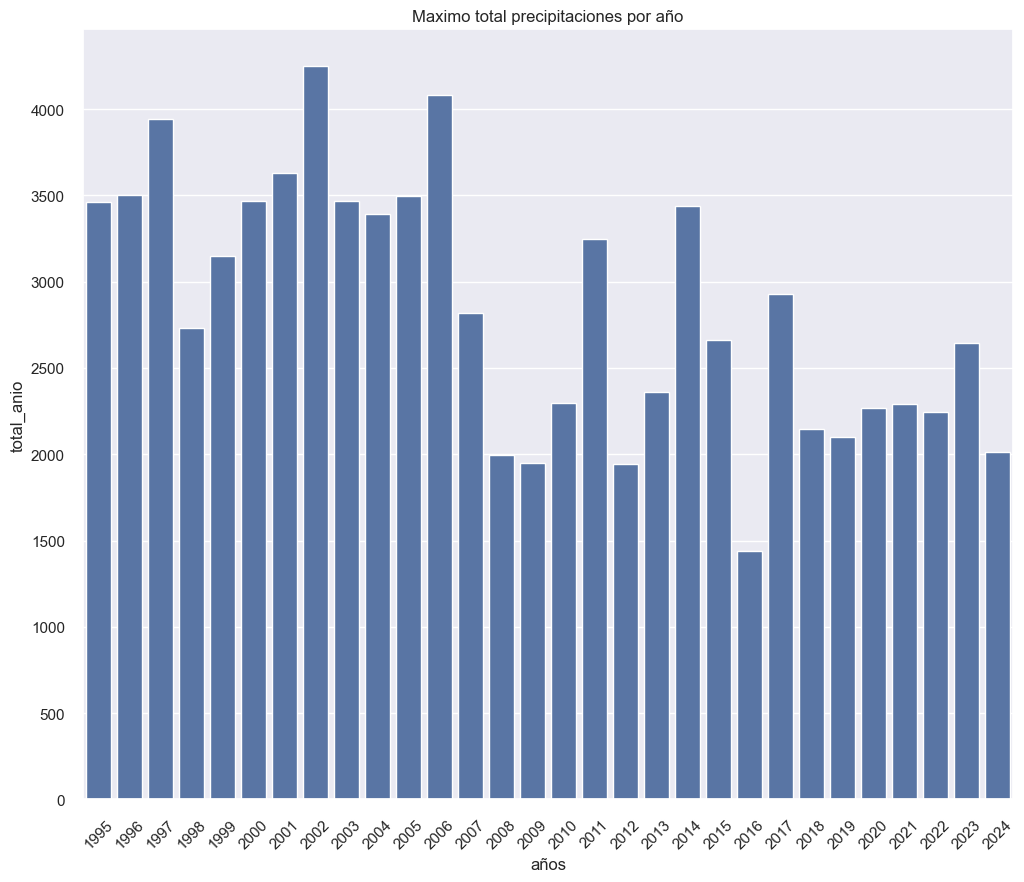

In [32]:
max_anios_df = pd.DataFrame(
    [{
        "años": año,
        "cod_estacion": val[0],
        "total_anio": val[1]} for año, val in max_anio.items()]
)


fig, ax = plt.subplots(figsize=(12,10))
sns.barplot(x = max_anios_df['años'], y = max_anios_df['total_anio'])
ax.set_title("Maximo total precipitaciones por año")
ax.tick_params(axis='x', rotation=45)
plt.show()

In [45]:
maximos = list(max_anio.values())
maximos.sort(key= lambda x : x[1], reverse=True)
maximos 

[[420004, 4249.3],
 [420004, 4084.2],
 [420004, 3945.5],
 [420004, 3632.6],
 [420004, 3502.4],
 [420004, 3498.0],
 [420004, 3467.7],
 [420004, 3467.4],
 [420004, 3461.0],
 [430001, 3436.3],
 [420004, 3394.9],
 [430001, 3247.6],
 [420004, 3147.9],
 [450001, 2928.3],
 [420004, 2819.3],
 [420004, 2734.5],
 [430001, 2663.4],
 [360042, 2644.4],
 [450001, 2363.4],
 [450001, 2298.8],
 [390043, 2292.0],
 [390043, 2266.8],
 [420015, 2242.2],
 [430002, 2146.6],
 [450001, 2101.0],
 [420015, 2015.8],
 [390006, 1995.1],
 [390006, 1950.1],
 [450001, 1945.8],
 [420014, 1440.0]]

In [51]:
print("La estación con más precipitaciones, en todos los años, corresponde a : ")
est = data_inicial[data_inicial['features.properties.CodigoNacional'] == maximos[0][0]]
print(*est['features.properties.nombreEstacion'].values, end=" ")
print("de la región", *est['features.properties.NumeroRegion'])
anio = [k for k,v in max_anio.items() if v== maximos[0]]
anio = str( *anio)
print(f" En el año {anio}")


La estación con más precipitaciones, en todos los años, corresponde a : 
Chaitén, Ad. de la región 10
 En el año 2002


## 6. Desafios

Generar un dataframe que una el archivo `.shp` y los promedios de los últimos cinco años `[2024,2023,2022,2021,2020]`
de cada región a partir de los datos que hemos obtenido. Es decir, tendriamos algo como esto :

|name | ...|geometry| 2020|...|2024|
|-----|----|--------|-----|---|------|
|Arica ..| ...| POLYGON(...)| 10.5|...|9.3|
|...| ...|...|...|...|...|...|...|
|Magallanes| ...|POLYGON(...)|9.8|...|12.1|



In [34]:
data_inicial['features.properties.NumeroRegion'].unique()

array([13, 15,  2,  5,  3, 10, 12,  4,  1,  7,  8, 11, 16,  9, 14,  6])

In [35]:
chile 

,id,name,source,geometry
0,CLAP,Arica y Parinacota,https://simplemaps.com,"POLYGON ((-68.98961 -18.94649, -68.99043 -18.9..."
1,CLTA,TarapacÃ¡,https://simplemaps.com,"POLYGON ((-70.27033 -19.17148, -70.26956 -19.1..."
2,CLAN,Antofagasta,https://simplemaps.com,"POLYGON ((-70.06135 -21.44834, -70.05853 -21.4..."
3,CLAT,Atacama,https://simplemaps.com,"POLYGON ((-70.63464 -26.02863, -70.63455 -26.0..."
4,CLCO,Coquimbo,https://simplemaps.com,"POLYGON ((-71.48712 -29.21134, -71.48697 -29.2..."
5,CLRM,RegiÃ³n Metropolitana de Santiago,https://simplemaps.com,"POLYGON ((-70.1061 -33.05259, -70.10528 -33.05..."
6,CLVS,ValparaÃ­so,https://simplemaps.com,"POLYGON ((-71.54384 -32.19303, -71.54377 -32.1..."
7,CLML,Maule,https://simplemaps.com,"POLYGON ((-70.37245 -35.02739, -70.36852 -35.0..."
8,CLLI,Libertador General Bernardo O'Higgins,https://simplemaps.com,"POLYGON ((-71.71794 -33.97116, -71.71208 -33.9..."
9,CLNB,Ãuble,https://simplemaps.com,"POLYGON ((-72.79914 -36.0531, -72.79501 -36.05..."


Luego podemos plotear el mapa de Chile en función de estos promedios para cada año  que escogimos. Podriamos ver algo como esto :


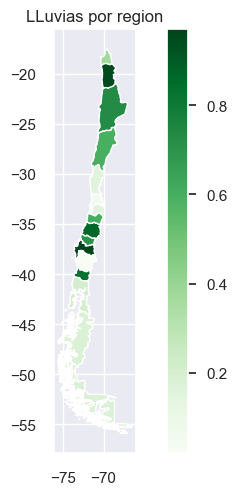

In [36]:
chile['promedio_X'] = np.random.rand(len(chile)) # creamos datos aleatorios para la muestra
chile.plot(cmap="Greens", column= 'promedio_X', legend=True)
plt.title('LLuvias por region');

## 8. Conclusión

En esta ayudantía:
- Practicamos exploración inicial de un dataset con `pandas`.
- Realizamos agrupaciones y análisis descriptivo por estaciones y años.
- Visualizamos datos con gráficos y mapas coropléticos.
- (Opcionalmente) Pueden animar  la evolución temporal de precipitaciones [a partir del ejercicio dejado como desafio].

### Preguntas abiertas
- ¿Qué patrones espaciales se observan en la precipitación?
- ¿Qué regiones presentan mayor variabilidad interanual?
